<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Dataset-Information" data-toc-modified-id="Dataset-Information-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Dataset Information</a></span></li><li><span><a href="#Clean-Dataset" data-toc-modified-id="Clean-Dataset-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Clean Dataset</a></span><ul class="toc-item"><li><span><a href="#Nans" data-toc-modified-id="Nans-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Nans</a></span></li><li><span><a href="#Outliers" data-toc-modified-id="Outliers-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Outliers</a></span></li><li><span><a href="#Dummy-Variables" data-toc-modified-id="Dummy-Variables-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Dummy Variables</a></span></li></ul></li><li><span><a href="#Feature-Visualizations" data-toc-modified-id="Feature-Visualizations-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Feature Visualizations</a></span></li></ul></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Determine-Best-Model" data-toc-modified-id="Determine-Best-Model-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Determine Best Model</a></span></li><li><span><a href="#Evaluating-Best-Model" data-toc-modified-id="Evaluating-Best-Model-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Evaluating Best Model</a></span></li></ul></li><li><span><a href="#External-Feature:-Interest-Rate" data-toc-modified-id="External-Feature:-Interest-Rate-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>External Feature: Interest Rate</a></span></li></ul></div>

# Introduction

- Load the houseprices data from Thinkful's database.
- Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.
- Now, split your data into train and test sets where 20% of the data resides in the test set.
- Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!
- Evaluate your best model on the test set.
- So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.


# Imports

In [3]:
from sqlalchemy import create_engine

from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from scipy.stats import bartlett
from scipy.stats import levene
from scipy.stats import boxcox
from scipy.stats.mstats import winsorize

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV, RidgeCV, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GridSearchCV


%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 150
pd.options.display.max_rows = 150

In [4]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
housing_df = pd.read_sql_query('select * from houseprices', con=engine)

engine.dispose()

#used for outlier section
original_df = housing_df.copy()

OperationalError: (psycopg2.OperationalError) could not connect to server: Network is unreachable
	Is the server running on host "142.93.121.174" and accepting
	TCP/IP connections on port 5432?
 (Background on this error at: http://sqlalche.me/e/e3q8)

# EDA

## Dataset Information

In [3]:
housing_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


In [4]:
categorical_features = 0
int_feature = 0
for col in housing_df.columns:
    if housing_df[col].dtype == 'O':
        categorical_features += 1
    else:
        int_feature += 1
print('Total columns:', len(housing_df.columns))
print('Numerical columns:', int_feature)
print('Categorical columns:', categorical_features)

Total columns: 81
Numerical columns: 38
Categorical columns: 43


## Clean Dataset

### Nans

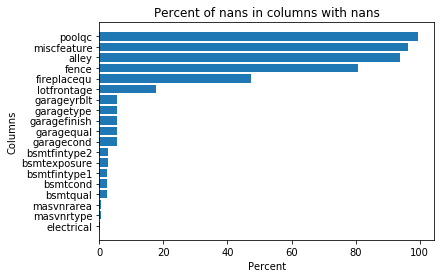

In [5]:
# see percent of nan values within each column
nan_col = housing_df.isnull().sum()/ len(housing_df)*100
nan_col = nan_col.drop(nan_col[nan_col == 0].index).sort_values(ascending=True)
plt.barh(nan_col.keys(),nan_col.values)
plt.title('Percent of nans in columns with nans')
plt.ylabel('Columns')
plt.xlabel('Percent')
plt.show()

Categorical columns with nans can be just filled with the string "None". This is only the case if the nan values represents an absence of that feature within the house (e.g. Nan value in fence column = No fence). 

The nans within numeric columns such as garageyrblt (garage year built) and masvnrarea (Masonry veneer area in square feet), can be replaced with zeros since nans within those columns are likely to also represent an absence of those features. 

Looking at a great [notebook](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard) created by Serigne, I used his idea of using median imputation for the lot frontage column (Linear feet of street connected to property) ordered by neighborhood. This makes sense since houses within the same neighborhood are likely to have similar lot frontage value. 

In [6]:
fill_none_col = ['poolqc', 'miscfeature', 'alley', 'fence', 'fireplacequ', 'garagetype', 
                 'garagefinish', 'garagequal', 'garagecond', 'bsmtqual', 'bsmtcond', 'bsmtexposure',
                 'bsmtfintype1', 'bsmtfintype2', 'masvnrtype', 'electrical']
for col in fill_none_col:
    housing_df[col] = housing_df[col].fillna('None')

fill_zero_col = ['garageyrblt', 'masvnrarea']
for col in fill_zero_col:
    housing_df[col] = housing_df[col].fillna(0)
    
housing_df['lotfrontage'] = housing_df.groupby("neighborhood")["lotfrontage"].transform(
    lambda x: x.fillna(x.median()))

#impute nans with mean of yearbuilt

housing_df.yearbuilt = housing_df.yearbuilt.replace(0, np.nan)
housing_df.yearbuilt = housing_df.yearbuilt.fillna(housing_df.yearbuilt.mean())

### Outliers

The difference between the max value and the 75th percentile of some numeric features are significantly large. Those feature's respective max values are likely to be outliers.

In [7]:
housing_df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.199658,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1868.739726,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,22.431902,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,453.697295,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1958.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,70.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1977.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


The turkey method is used to find the outliers that are beyond a threshold outside of the 25th or 75th percentile. Observations that are beyond that threshold are capped at the max/min threshold value using the winsorize method. Since some of the feature's median and interquartile are zero, all observations other than zero are considered outliers before winsorizing the feature. This leads to the issue of the winsorizing method to capp all observations at zero. The if statement within the loop fixes this issue by only using non-zero values for calculating the percentiles and winsorizing only those set of values.  

mssubclass
Feature: mssubclass ... outliers: 103 ... percentage 7.054794520547945


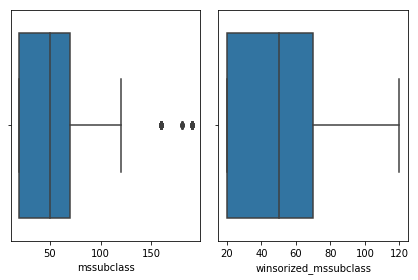

lotfrontage
Feature: lotfrontage ... outliers: 93 ... percentage 6.36986301369863


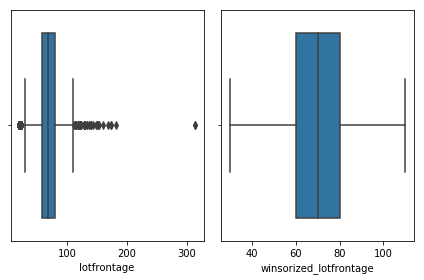

lotarea
Feature: lotarea ... outliers: 69 ... percentage 4.726027397260274


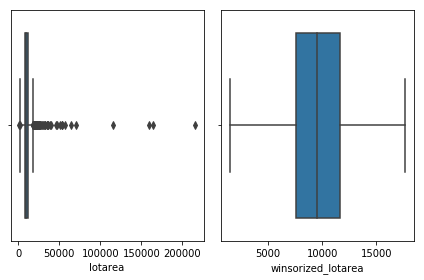

overallqual
Feature: overallqual ... outliers: 2 ... percentage 0.136986301369863


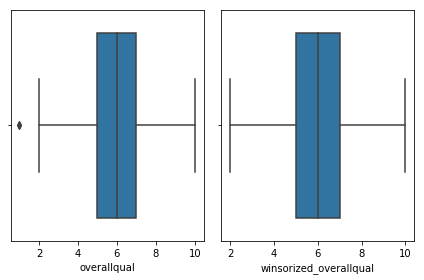

overallcond
Feature: overallcond ... outliers: 125 ... percentage 8.561643835616438


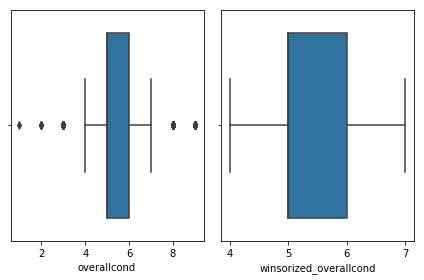

yearbuilt
Feature: yearbuilt ... outliers: 7 ... percentage 0.4794520547945206


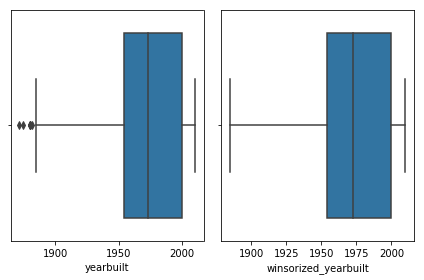

yearremodadd
Feature: yearremodadd ... outliers: 0 ... percentage 0.0


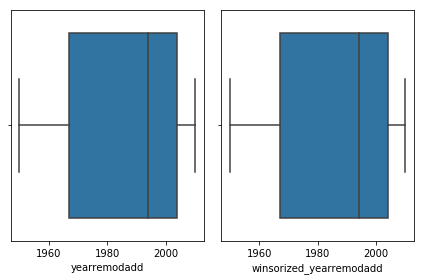

masvnrarea
Feature: masvnrarea ... outliers: 28 ... percentage 1.9178082191780823


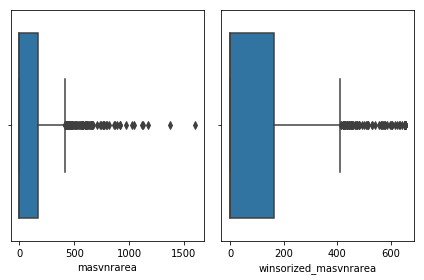

bsmtfinsf1
Feature: bsmtfinsf1 ... outliers: 7 ... percentage 0.4794520547945206


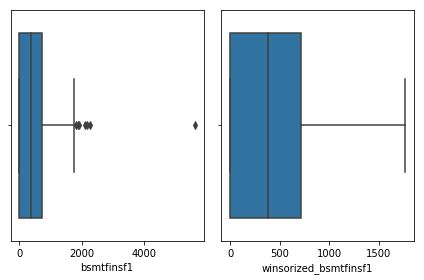

bsmtfinsf2
Feature: bsmtfinsf2 ... outliers: 3 ... percentage 0.2054794520547945


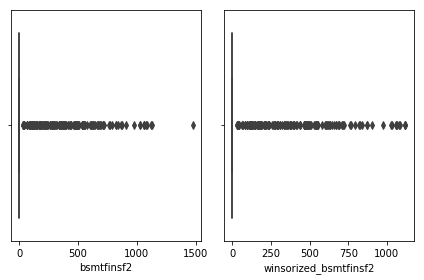

bsmtunfsf
Feature: bsmtunfsf ... outliers: 29 ... percentage 1.9863013698630139


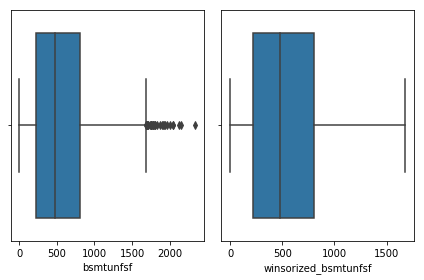

totalbsmtsf
Feature: totalbsmtsf ... outliers: 61 ... percentage 4.178082191780822


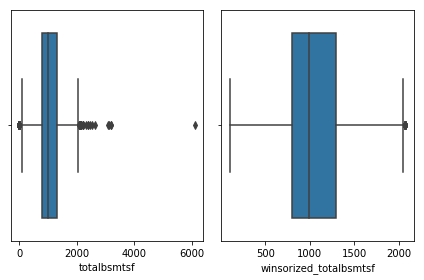

firstflrsf
Feature: firstflrsf ... outliers: 20 ... percentage 1.36986301369863


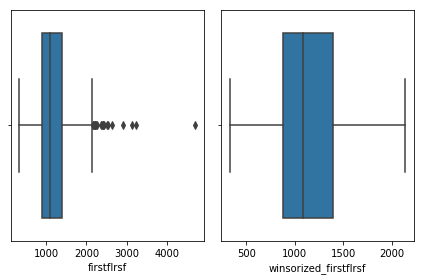

secondflrsf
Feature: secondflrsf ... outliers: 17 ... percentage 1.1643835616438356


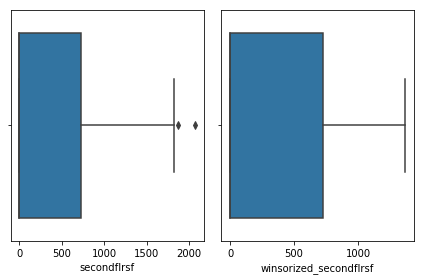

lowqualfinsf
Feature: lowqualfinsf ... outliers: 0 ... percentage 0.0


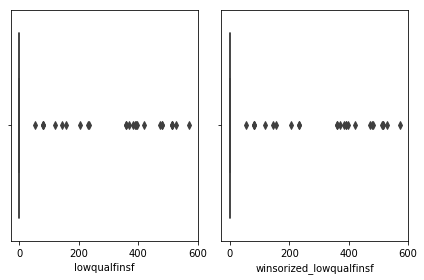

grlivarea
Feature: grlivarea ... outliers: 31 ... percentage 2.1232876712328768


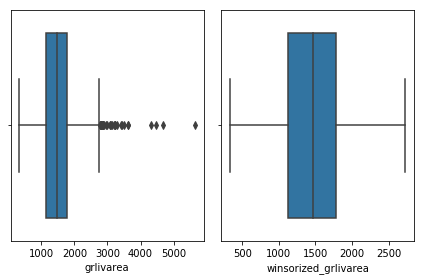

bsmtfullbath
Feature: bsmtfullbath ... outliers: 16 ... percentage 1.095890410958904


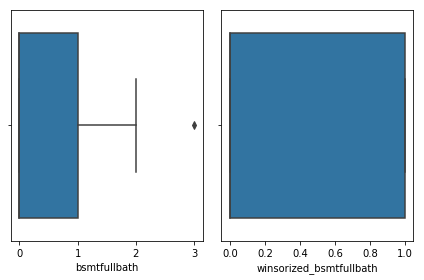

bsmthalfbath
Feature: bsmthalfbath ... outliers: 2 ... percentage 0.136986301369863


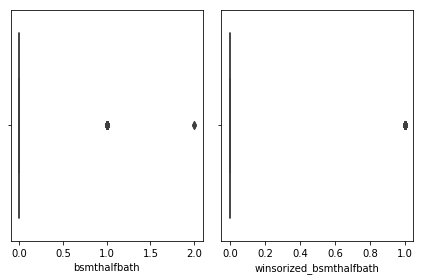

fullbath
Feature: fullbath ... outliers: 0 ... percentage 0.0


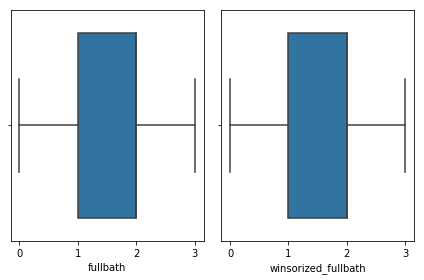

halfbath
Feature: halfbath ... outliers: 12 ... percentage 0.821917808219178


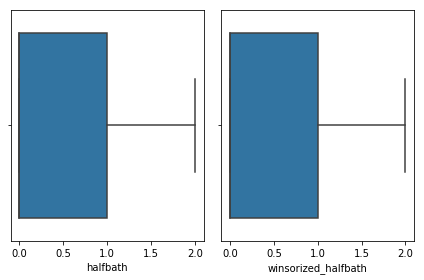

bedroomabvgr
Feature: bedroomabvgr ... outliers: 35 ... percentage 2.3972602739726026


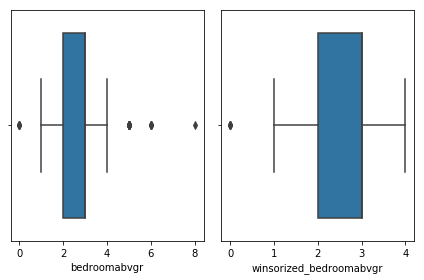

kitchenabvgr


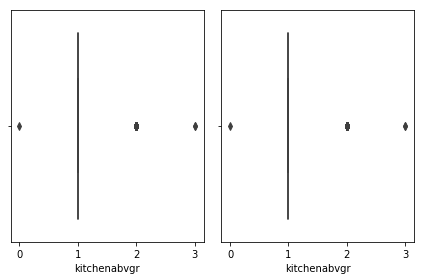

totrmsabvgrd
Feature: totrmsabvgrd ... outliers: 30 ... percentage 2.054794520547945


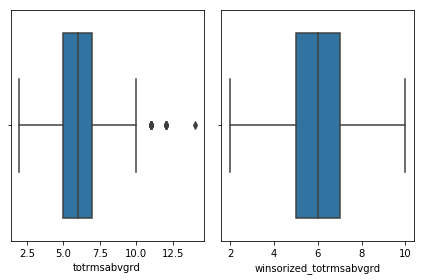

fireplaces
Feature: fireplaces ... outliers: 5 ... percentage 0.3424657534246575


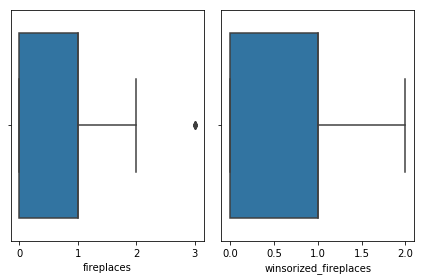

garageyrblt
Feature: garageyrblt ... outliers: 81 ... percentage 5.5479452054794525


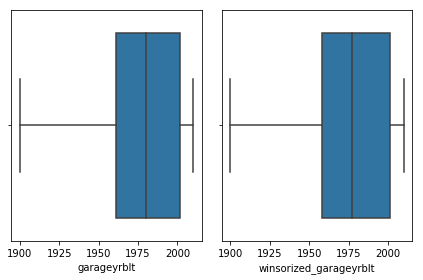

garagecars
Feature: garagecars ... outliers: 5 ... percentage 0.3424657534246575


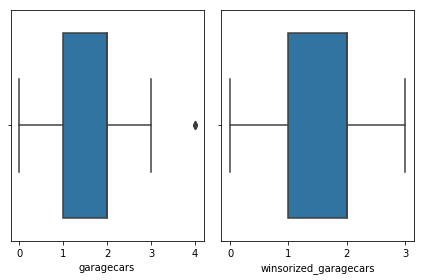

garagearea
Feature: garagearea ... outliers: 21 ... percentage 1.4383561643835616


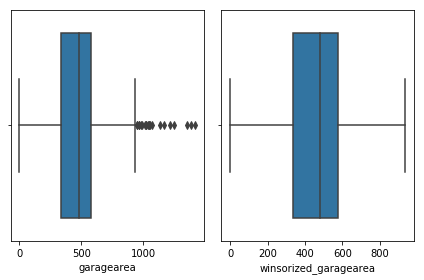

wooddecksf
Feature: wooddecksf ... outliers: 32 ... percentage 2.191780821917808


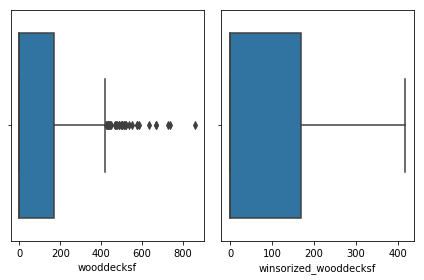

openporchsf
Feature: openporchsf ... outliers: 77 ... percentage 5.273972602739726


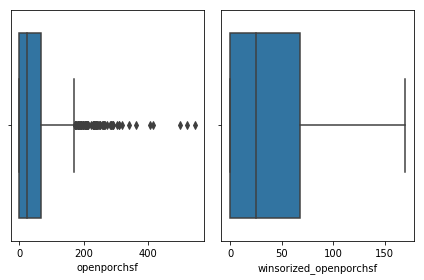

enclosedporch
Feature: enclosedporch ... outliers: 2 ... percentage 0.136986301369863


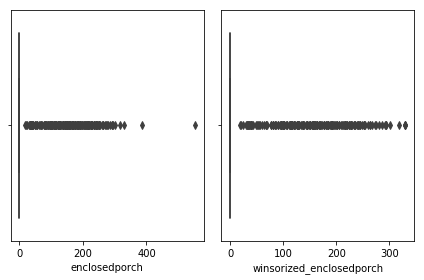

threessnporch
Feature: threessnporch ... outliers: 2 ... percentage 0.136986301369863


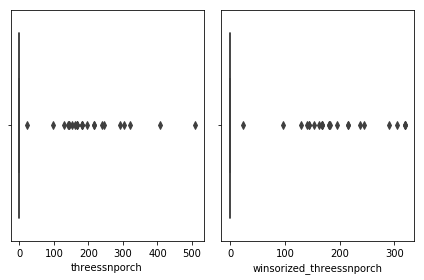

screenporch
Feature: screenporch ... outliers: 6 ... percentage 0.410958904109589


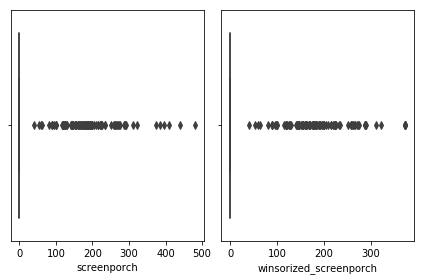

poolarea
Feature: poolarea ... outliers: 0 ... percentage 0.0


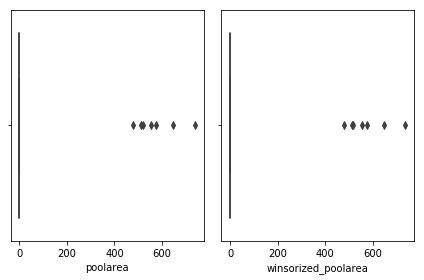

miscval
Feature: miscval ... outliers: 8 ... percentage 0.547945205479452


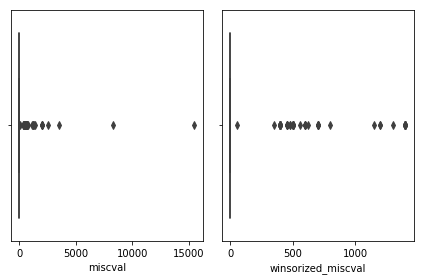

mosold
Feature: mosold ... outliers: 0 ... percentage 0.0


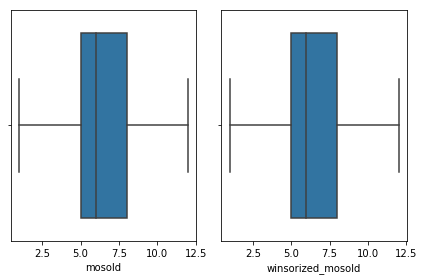

yrsold
Feature: yrsold ... outliers: 0 ... percentage 0.0


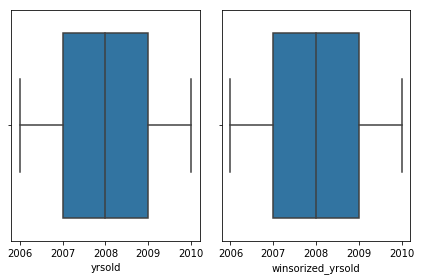

saleprice


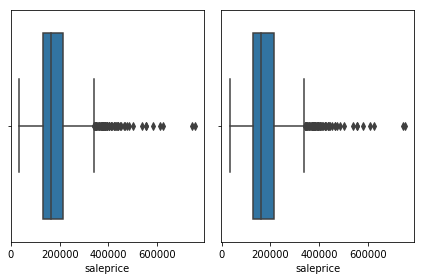

In [8]:
num_col = [col for col in housing_df.columns if (housing_df[col].dtypes == 'int64') or (housing_df[col].dtypes == 'float64')]

for num in range(1, len(num_col)):
    print(num_col[num])
    if num_col[num] not in ['kitchenabvgr', 'saleprice']:
        if housing_df[num_col[num]].median() == 0:
            data = housing_df[num_col[num]][housing_df[num_col[num]] != 0]
            q25, q75 = np.percentile(data, [25,75])
            iqr = q75 - q25
            min_val = 0
            max_val = q75 + (iqr*1.5)

        else:
            data = housing_df[num_col[num]]
            q25, q75 = np.percentile(data, [25,75])
            iqr = q75 - q25
            min_val = q25 - (iqr*1.5)
            max_val = q75 + (iqr*1.5)


        min_outliers, max_outliers = len(np.where(housing_df[num_col[num]] < min_val)[0]), len(np.where(housing_df[num_col[num]] > max_val)[0])
        total_outliers = min_outliers + max_outliers
        min_pct, max_pct = min_outliers/len(housing_df), max_outliers/len(housing_df)
        total_pct_outliers = total_outliers /len(housing_df) * 100
        housing_df['winsorized_'+ num_col[num]] = winsorize(housing_df[num_col[num]], (min_pct, max_pct))
        housing_df.drop(num_col[num], inplace=True, axis=1)
        
        print("Feature: {} ... outliers: {} ... percentage {}".format(''.join([num_col[num]]), total_outliers, total_pct_outliers))
        
        plt.subplot(1,2,1)
        sns.boxplot(original_df[num_col[num]])

        plt.subplot(1,2,2)
        sns.boxplot(housing_df['winsorized_'+ num_col[num]])

        plt.tight_layout()
        plt.show()
    else:
        plt.subplot(1,2,1)
        sns.boxplot(housing_df[num_col[num]])

        plt.subplot(1,2,2)
        sns.boxplot(housing_df[num_col[num]])

        plt.tight_layout()
        plt.show()

### Dummy Variables

In [9]:
# create dummy variables for categorical features
binary_count = 0
for col in housing_df.columns:
    # create dummy variables for binary features
    if (housing_df[col].dtype == 'O') and (len(housing_df[col].value_counts()) == 2):
        binary_col = housing_df[col].value_counts().keys()[0]
        housing_df["is_" + binary_col] = pd.get_dummies(housing_df[col], drop_first=True)
        binary_count += 1
        housing_df.drop(col, axis=1, inplace=True)
    # create dummy variables for other multi-category features
    elif (housing_df[col].dtype == 'O') and (len(housing_df[col].value_counts()) != 2):
        housing_df = pd.concat([housing_df, pd.get_dummies(housing_df[col], prefix=col)], axis=1)
        binary_count += 1
        housing_df.drop(col, axis=1, inplace=True)

In [10]:
housing_df.head()

,id,kitchenabvgr,saleprice,winsorized_mssubclass,winsorized_lotfrontage,winsorized_lotarea,winsorized_overallqual,winsorized_overallcond,winsorized_yearbuilt,winsorized_yearremodadd,winsorized_masvnrarea,winsorized_bsmtfinsf1,winsorized_bsmtfinsf2,winsorized_bsmtunfsf,winsorized_totalbsmtsf,winsorized_firstflrsf,winsorized_secondflrsf,winsorized_lowqualfinsf,winsorized_grlivarea,winsorized_bsmtfullbath,winsorized_bsmthalfbath,winsorized_fullbath,winsorized_halfbath,winsorized_bedroomabvgr,winsorized_totrmsabvgrd,winsorized_fireplaces,winsorized_garageyrblt,winsorized_garagecars,winsorized_garagearea,winsorized_wooddecksf,winsorized_openporchsf,winsorized_enclosedporch,winsorized_threessnporch,winsorized_screenporch,winsorized_poolarea,winsorized_miscval,winsorized_mosold,winsorized_yrsold,mszoning_C (all),mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,is_Pave,alley_Grvl,alley_None,alley_Pave,lotshape_IR1,lotshape_IR2,lotshape_IR3,lotshape_Reg,landcontour_Bnk,landcontour_HLS,landcontour_Low,landcontour_Lvl,is_AllPub,lotconfig_Corner,lotconfig_CulDSac,lotconfig_FR2,lotconfig_FR3,lotconfig_Inside,landslope_Gtl,landslope_Mod,landslope_Sev,neighborhood_Blmngtn,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_IDOTRR,neighborhood_MeadowV,...,electrical_Mix,electrical_None,electrical_SBrkr,kitchenqual_Ex,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA,functional_Maj1,functional_Maj2,functional_Min1,functional_Min2,functional_Mod,functional_Sev,functional_Typ,fireplacequ_Ex,fireplacequ_Fa,fireplacequ_Gd,fireplacequ_None,fireplacequ_Po,fireplacequ_TA,garagetype_2Types,garagetype_Attchd,garagetype_Basment,garagetype_BuiltIn,garagetype_CarPort,garagetype_Detchd,garagetype_None,garagefinish_Fin,garagefinish_None,garagefinish_RFn,garagefinish_Unf,garagequal_Ex,garagequal_Fa,garagequal_Gd,garagequal_None,garagequal_Po,garagequal_TA,garagecond_Ex,garagecond_Fa,garagecond_Gd,garagecond_None,garagecond_Po,garagecond_TA,paveddrive_N,paveddrive_P,paveddrive_Y,poolqc_Ex,poolqc_Fa,poolqc_Gd,poolqc_None,fence_GdPrv,fence_GdWo,fence_MnPrv,fence_MnWw,fence_None,miscfeature_Gar2,miscfeature_None,miscfeature_Othr,miscfeature_Shed,miscfeature_TenC,saletype_COD,saletype_CWD,saletype_Con,saletype_ConLD,saletype_ConLI,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_Abnorml,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial
0,1,1,208500,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,2,1,181500,20,80.0,9600,6,7,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,3,1,223500,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,4,1,140000,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,5,1,250000,60,84.0,14260,8,5,2000,2000,350.0,655,0,4

## Feature Visualizations

According to [Homeia](https://homeia.com/10-important-features-to-consider-when-buying-a-house/), some of the most important factors for house prices are:

- Location
- Square Feet
- Number of bedrooms/bathrooms
- House quality interior/exterior
- Year Built

Lets see if these specific features or other features have a strong correlation with sale price.

/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(obj)


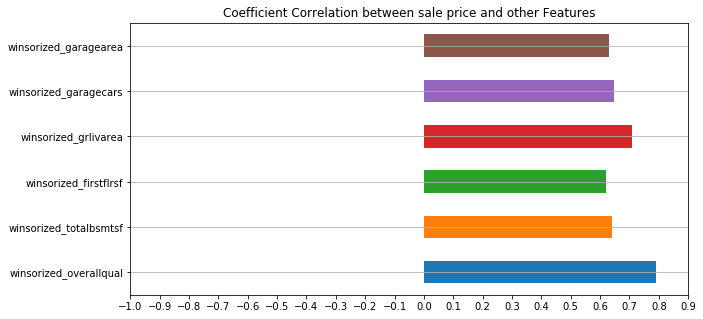

In [11]:
# plot features with coefficient correlations stronger than .6 in regards to sale price.
corr = housing_df.corr()
plot_corr = corr[(corr.saleprice > .6) | (corr.saleprice < -.6)]
plot_corr = plot_corr.saleprice
plot_corr.drop('saleprice', inplace=True)

plt.figure(figsize=(10, 5))
plot_corr.plot(kind='barh', grid=True)
plt.grid(axis='x')
plt.title('Coefficient Correlation between sale price and other Features')
plt.xticks(np.arange(-1, 1, .1))
plt.show()    

The overallqual feature (Overall material and finish quality) had the strongest correlation with sale price. This  relates to the house quality interior/exterior factor mentioned above in the list. 

The grlivarea (total above ground living area square feet), firstflrsf (first floor square feet) and totalbsmtsf (total basement square feet) all had a somewhat strong correlation with sale price. Since first floor square feet and second floor square feet are proportional to above ground square feet, we can just keep above ground living area out of the three. 


We can also assume that garagearea and garagecars are proportional to one another (more square feet = more space for cars) so we can exclude one of them within the modeling process.  

Surprisingly location and number of bedrooms/bathrooms were not strongly correlated with sale price. 

In [12]:
drop_col = ['winsorized_garagearea', 'winsorized_firstflrsf', 'winsorized_secondflrsf']
housing_df.drop(drop_col, axis=1, inplace=True)

# Modeling

## Determine Best Model

In [13]:
def model_results(model_list, train_x, train_y, test_x, test_y):
    scoring = ['fit_time', 'score_time', 'test_r2', 'train_r2', 'test_neg_mean_absolute_error',
               'train_neg_mean_absolute_error', 'test_neg_mean_squared_error', 'train_neg_mean_squared_error']

    model_dict = []
    for name, model in model_list.items():
        print(name)
        model_stats = {}
        
        alpha_dict = {'alpha': [.01,.1,1,10,100,1000]}
        if name in ['elastic', 'lasso']:
            model = GridSearchCV(model, alpha_dict, cv=3)
            model.fit(train_x, train_y)
            model_stats['best_alpha'] = model.best_params_['alpha']
            model_stats['coef'] = model.best_estimator_.coef_
        else:
            model.fit(train_x,train_y)
            model_stats['coef'] = np.around(model.coef_)
            if name != 'linear':
                model_stats['best_alpha'] = model.alpha_
        
        pred_y = model.predict(test_x)
        
        model_stats['r2'] = model.score(test_x, test_y)
        model_stats['root_MSE'] = np.sqrt(mse(test_y, pred_y))
        model_stats['MAE'] = np.abs(test_y - pred_y).mean()
        model_stats['MAPE'] = (np.abs(test_y - pred_y) / test_y).mean() * 100
        model_stats['model_name'] = name
        
        
        model_dict.append(model_stats)
            
    model_df = pd.DataFrame(model_dict).set_index('model_name')

    return model_df

In [14]:
all_feature_list = list(housing_df.loc[:,housing_df.columns != 'saleprice'].columns[2:])

train_x, test_x, train_y, test_y = train_test_split(
    housing_df[all_feature_list], housing_df['saleprice'], test_size=.2)

elastic = ElasticNet()
ridge = RidgeCV(alphas=(.01,1,10,100,1000))
lasso = Lasso()
linear = LinearRegression()
model_list = {'elastic': elastic, 'ridge': ridge, 'lasso': lasso, 'linear': linear}

model_df = model_results(model_list, train_x, train_y, test_x, test_y)

elastic


/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

ridge
lasso


/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

linear


/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [15]:
model_df

,MAE,MAPE,best_alpha,coef,r2,root_MSE
model_name,,,,,,
elastic,15317.574114,9.957837,0.1,"[-128.10056680920533, 2.6595297943691074, 1.61...",0.909577,20394.275732
ridge,14854.191826,9.603852,10.0,"[-126.0, -18.0, 2.0, 10409.0, 6590.0, 126.0, 1...",0.910251,20318.143006
lasso,14564.415411,9.246445,100.0,"[-133.8112250312821, -1.1712799761170787, 1.54...",0.916049,19650.901648
linear,23013.848853,13.203317,NaN,"[-66.0, 5.0, 2.0, 8461.0, 6235.0, 254.0, 161.0...",-0.788576,90703.175927


Using all features within the dataset, the lasso model performed the best in all scoring metrics. Although after multiple iterations, the Ridge and ElasticNet model were occasionally the top models in regards to MAE, MAPE, and root MSE.

## Evaluating Best Model

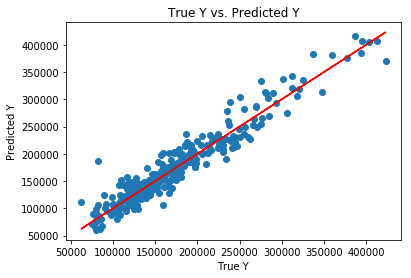

R2:  0.9160487278339674
RMSE: 19650.901648023242
MAE: 14564.415411350043
MAPE: 9.246445402341399
Alpha:  100


In [16]:
lasso = Lasso(alpha=100)
lasso.fit(train_x, train_y)
pred_y = lasso.predict(test_x)

plt.scatter(test_y, pred_y)
plt.plot(test_y, test_y, color='red')
plt.title('True Y vs. Predicted Y')
plt.xlabel('True Y')
plt.ylabel('Predicted Y')
plt.show()

print('R2: ', lasso.score(test_x, test_y))
print('RMSE:', rmse(test_y, pred_y))
print('MAE:', mean_absolute_error(test_y, pred_y))
print('MAPE:', (np.abs(test_y - pred_y) / test_y).mean() *100)
print('Alpha: ', lasso.alpha)

The Lasso model performed well in regards to R^2 score. Although looking at the predicted-y vs test y plot, the model significantly underestimated some of the high value observations. 


Bartlett test statistic value is 378.524 and p value is 2.61e-84
Levene test statistic value is 162.044 and p value is 6.38e-33


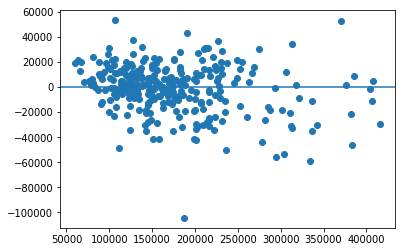

In [17]:
error_term = test_y - pred_y
plt.scatter(pred_y, error_term)
plt.axhline(y=0)


bart_stats = bartlett(pred_y, error_term)
lev_stats = levene(pred_y, error_term)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

The error term values are are not evenly distributed according to the Bartlett and Levene tests. If there were more high saleprice observations within the dataset, then the model may of been able to lower it's error terms for those high value observations. 

# External Feature: Interest Rate

The dictionary below is the annual average 30-year fixed-rate mortgage for residential housing according to the article [Historical Mortgage Rates](https://www.valuepenguin.com/mortgages/historical-mortgage-rates#nogo). We will match each observation's year sold column to the dictionary. 

In [18]:
avg_interest_rates = {2010: 4.69, 2009: 5.04, 2008: 6.03, 2007: 6.34, 2006: 6.41}

Since we are only focusing on residential real estate, we can drop the houses that aren't.

In [19]:
housing_df = housing_df[housing_df['mszoning_C (all)'] == 0]
housing_df = housing_df[housing_df['mszoning_FV'] == 0]

housing_df['interest_rate'] = housing_df.winsorized_yrsold.apply(lambda x: avg_interest_rates[x])

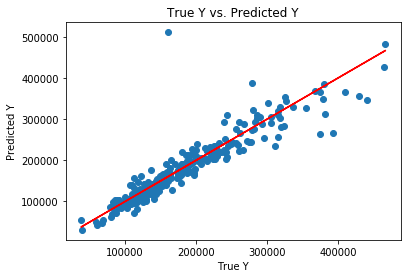

R2:  0.8390035873721521
RMSE: 31799.2118117708
MAE: 17399.516998073846
MAPE: 9.9081127381417
Alpha:  100


In [20]:
all_feature_list = list(housing_df.loc[:,housing_df.columns != 'saleprice'].columns[2:])

train_x, test_x, train_y, test_y = train_test_split(
    housing_df[all_feature_list], housing_df['saleprice'], test_size=.2)

lasso = Lasso(alpha=100)
lasso.fit(train_x, train_y)
pred_y = lasso.predict(test_x)

plt.scatter(test_y, pred_y)
plt.plot(test_y, test_y, color='red')
plt.title('True Y vs. Predicted Y')
plt.xlabel('True Y')
plt.ylabel('Predicted Y')
plt.show()

print('R2: ', lasso.score(test_x, test_y))
print('RMSE:', rmse(test_y, pred_y))
print('MAE:', mean_absolute_error(test_y, pred_y))
print('MAPE:', (np.abs(test_y - pred_y) / test_y).mean() *100)
print('Alpha: ', lasso.alpha)

In [21]:
interest_rate_index = all_feature_list.index('interest_rate')
print('Interest Rate Coefficient: ', lasso.coef_[interest_rate_index])

Interest Rate Coefficient:  0.0


Interest rates do not contribute to the sale price prediction within the Lasso model. This Lasso model performed worst than the original lasso model since I used a slightly smaller subset of only residential properties. 